In [1]:
import matplotlib
import seaborn
import pandas
import gzip
import igraph
import itertools
import re
import os

#import statsmodels
#import scipy.stats

from collections import Counter, OrderedDict

%matplotlib inline

seaborn.set_style('whitegrid')
seaborn.set_palette('colorblind')

In [2]:
ecosystems = ['npm', 'cran', 'rubygems']

COLORS = {ecos: seaborn.color_palette()[i] for i, ecos in enumerate(ecosystems)}
FIG_SIZE = (6, 3)
FIG_SIZE_WIDE = (10, 3)
SHOW_TITLE = True

def savefig(fig, name):
    # Uncomment next line to disable export
    return
    return fig.savefig('figures/{}.pdf'.format(name), bbox_inches='tight')

## Read graphs

In [3]:
GRAPH_DIR = '/data/graphs'

def read_graph(filename):
    g = igraph.read(os.path.join(GRAPH_DIR, filename), format='graphmlz')
    date = re.search(r'(\d\d\d\d-\d\d-\d\d)', filename).group(1)
    return date, g
    
def read_graphs(e):
    return [read_graph(f) for f in os.listdir(GRAPH_DIR)
            if re.search(r'^{}.*\.graphml\.gz'.format(e), f)]

graphs = OrderedDict((e, dict(read_graphs(e))) for e in ecosystems)

## Compute metrics

In [4]:
def graph_metrics(g, d, e):
    return {'time': d, 'ecos': e, 'size': len(g.vs),
            'biggest_wcc': len(g.components(igraph.WEAK).giant().vs) if len(g.vs) else 0,
            'with_deps': len([x for x in g.outdegree() if x > 0]),
            'with_revdeps': len([x for x in g.indegree() if x > 0]),
            'isolated': len([x for x in g.degree() if x == 0])}

def ecos_metrics(e, x):
    metrics = pandas.DataFrame([graph_metrics(g, d, e) for d, g in x.items()])
    metrics['time'] = pandas.to_datetime(metrics.time)
    return metrics.set_index(['time']).sort_index()

ecos_metrics = OrderedDict((e, ecos_metrics(e, x)) for e, x in graphs.items())

In [5]:
dates = pandas.date_range('2012-01-01', '2016-01-01', freq='AS')

def package_metrics(e, g):
    data = [pandas.DataFrame({'date': d, 'package': g.vs['name'], 'size': g.vs['size'],
                              'indegree': g.indegree(), 'outdegree': g.outdegree()})
            for d, g in g.items() if d in dates]
    return (pandas.concat(data)
            .assign(isolated=lambda d: d.indegree + d.outdegree == 0)
            .sort_values('date'))

package_metrics = {e: package_metrics(e, g) for e, g in graphs.items()}

## Preferential attachment

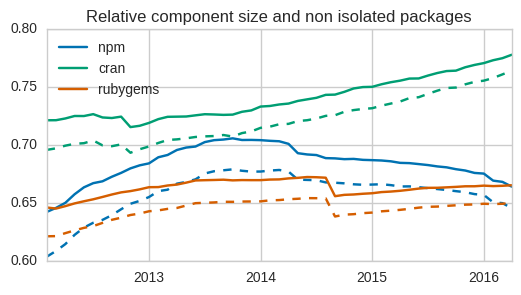

In [6]:
fig, ax = matplotlib.pyplot.subplots()
fig.set_size_inches(FIG_SIZE)
if SHOW_TITLE:
    ax.set_title('Relative component size and non isolated packages')
for e, m in ecos_metrics.items():
    data = (m.query('size > 1 and time > "2012"')
             .assign(biggest_wcc=lambda d: d.biggest_wcc / d['size'])
             .assign(isolated=lambda d: 1 - d.isolated / d['size']))
    data.biggest_wcc.plot(ax=ax, style='--', color=COLORS[e])
    data.isolated.plot(ax=ax, style='-', color=COLORS[e], label=e, legend=True)

ax.set_xlabel('')
ax.set_ylim(0.6,0.8)
savefig(fig, 'evol_component')
#ax.set_xlim(pandas.to_datetime('2000-01-01'))

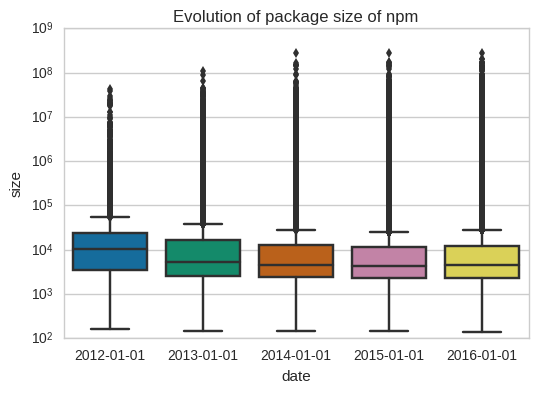

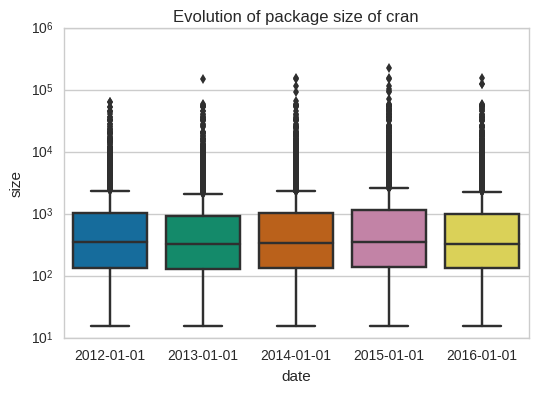

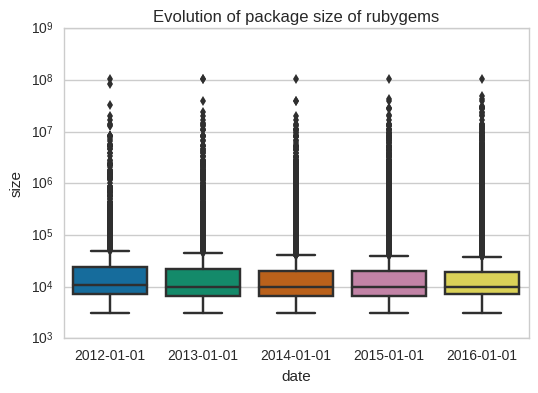

In [7]:
axes = {e: matplotlib.pyplot.subplots() for e, g in graphs.items()}

for e, data in package_metrics.items():
    ax = seaborn.boxplot(data=data, x='date', y='size', ax=axes[e][1])
    if SHOW_TITLE:
        ax.set_title('Evolution of package size of {}'.format(e))
    ax.set_yscale('log')

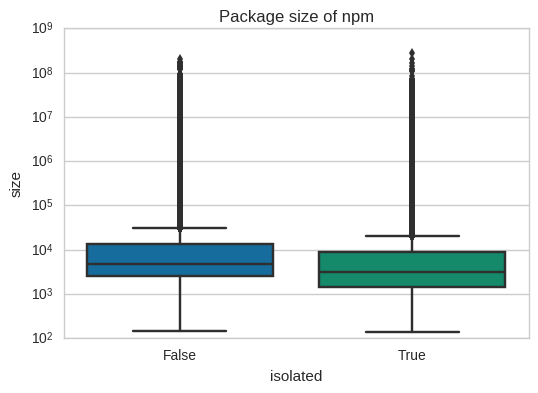

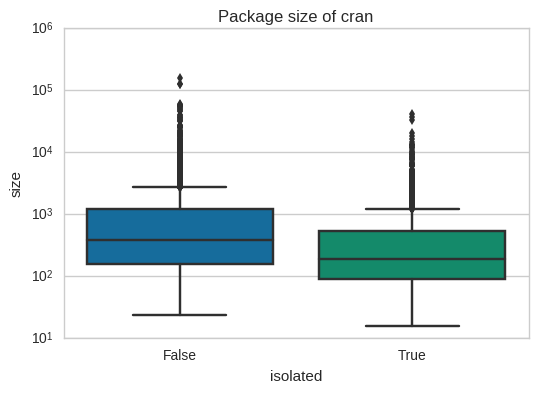

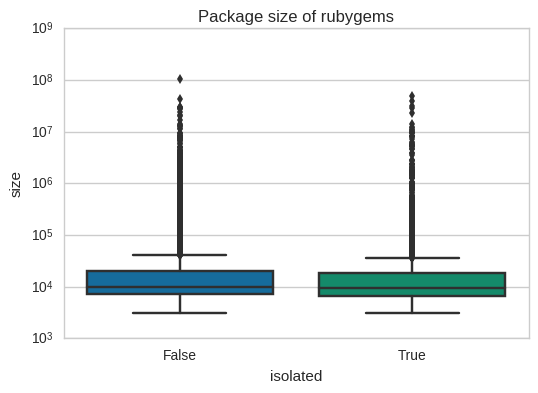

In [8]:
axes = {e: matplotlib.pyplot.subplots() for e, g in graphs.items()}

for e, data in package_metrics.items():
    ax = seaborn.boxplot(data=data[data.date == '2016-01-01'], x='isolated', y='size', ax=axes[e][1])
    if SHOW_TITLE:
        ax.set_title('Package size of {}'.format(e))
    ax.set_yscale('log')

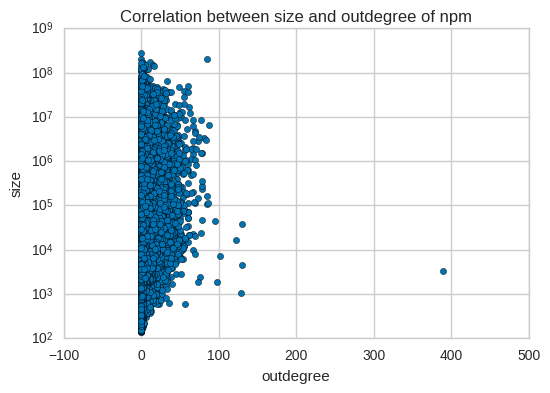

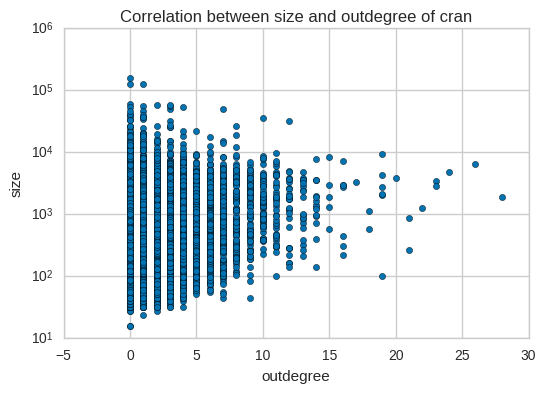

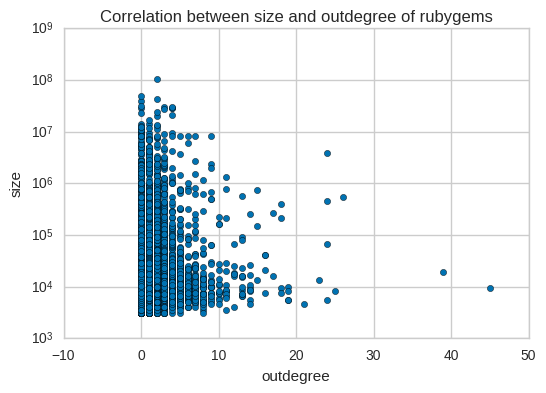

In [26]:
axes = {e: matplotlib.pyplot.subplots() for e, g in graphs.items()}

for e, data in package_metrics.items():
    ax = axes[e][1]
    data[data.date == '2016-01-01'].plot.scatter(x='outdegree', y='size', ax=ax)
    #ax = seaborn.jointplot(data=data[data.date == '2016-01-01'], x='indegree', y='size')
    if SHOW_TITLE:
        ax.set_title('Correlation between size and outdegree of {}'.format(e))
    #ax.set_xscale('log')
    ax.set_yscale('log')

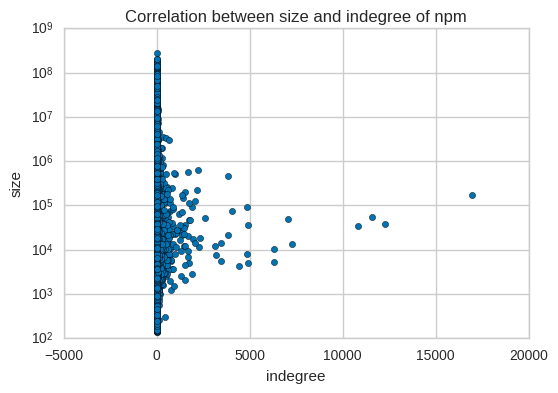

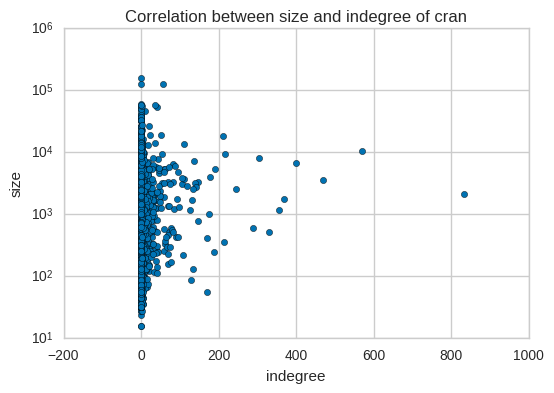

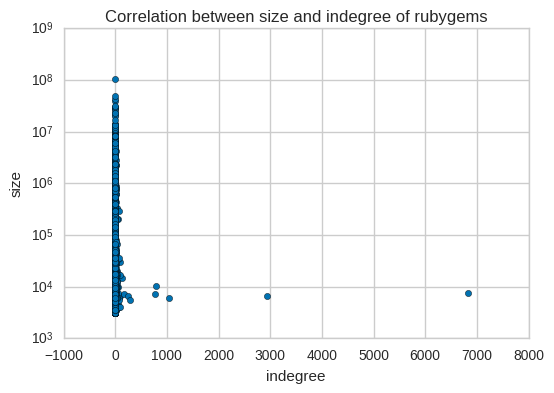

In [27]:
axes = {e: matplotlib.pyplot.subplots() for e, g in graphs.items()}

for e, data in package_metrics.items():
    ax = axes[e][1]
    data[data.date == '2016-01-01'].plot.scatter(x='indegree', y='size', ax=ax)
    #ax = seaborn.jointplot(data=data[data.date == '2016-01-01'], x='indegree', y='size')
    if SHOW_TITLE:
        ax.set_title('Correlation between size and indegree of {}'.format(e))
    #ax.set_xscale('log')
    ax.set_yscale('log')

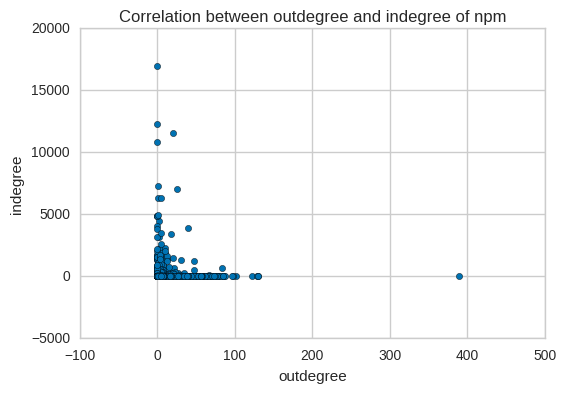

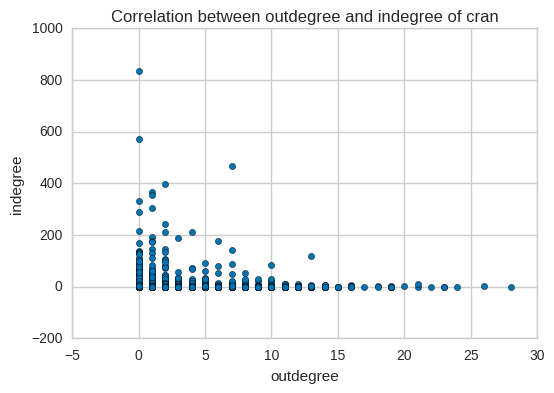

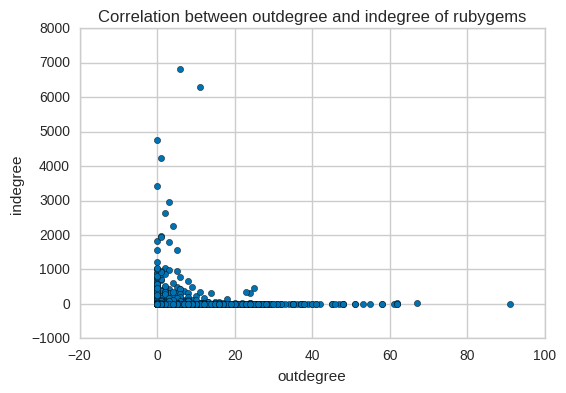

In [29]:
axes = {e: matplotlib.pyplot.subplots() for e, g in graphs.items()}

for e, data in package_metrics.items():
    ax = axes[e][1]
    data[data.date == '2016-01-01'].plot.scatter(x='outdegree', y='indegree', ax=ax)
    #ax = seaborn.jointplot(data=data[data.date == '2016-01-01'], x='indegree', y='size')
    if SHOW_TITLE:
        ax.set_title('Correlation between outdegree and indegree of {}'.format(e))
    #ax.set_xscale('log')
    #ax.set_yscale('log')